In [20]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from vmdpy import VMD
from scipy.fftpack import hilbert,fft,ifft
from math import log
import pandas as pd
import time

In [21]:
# data = np.loadtxt('ball18.txt')
# x = data[0:2048]
df = pd.read_csv('solar2019.csv',header=0, parse_dates=[0],index_col=0)# 读取CSV文件，并设置第一列为日期，作为索引
# print(df.head(10))
x = df.iloc[0:35040,-1].values
print(x.shape)
tau = 0.  # noise-tolerance (no strict fidelity enforcement)
DC = 0  # no DC part imposed
init = 1  # initialize omegas uniformly
tol = 1e-7

(35040,)


In [22]:
# #函数
def fun(K, alpha):
    if K < lb[0]:
        K = lb[0]
    if K > ub[0]:
        K = ub[0]
        
    if alpha < lb[1]:
        alpha = lb[1]
    if alpha > ub[1]:
        alpha =ub[1]

    # K = int(position[0])
    # alpha = position[1]
    u, u_hat, omega = VMD(x, alpha, tau, K, DC, init, tol)
    #  
    EP = []
    for i in range(K):
        H = np.abs(hilbert(u[i,:]))
        e1 = []
        for j in range(len(H)):
            p = H[j]/np.sum(H)
            e = -p*log(p,2)
            e1.append(e)
        E = np.sum(e1)  
        EP.append(E)
    s = np.sum(EP)/K
    return s

# import numpy as np

# def fitness(K, alpha):
#     if K < lb[0]:
#         K = lb[0]
#     if K > ub[0]:
#         K = ub[0]
        
#     if alpha < lb[1]:
#         alpha = lb[1]
#     if alpha > ub[1]:
#         alpha = ub[1]

#     # K = int(position[0])
#     # alpha = position[1]
#     u, u_hat, omega = VMD(x, alpha, tau, K, DC, init, tol)
#     #  
#     LSE = []
#     for i in range(K):
#         H = np.abs(hilbert(u[i,:]))
#         e1 = []
#         for j in range(len(H)):
#             p = H[j]/np.sum(H)
#             e = -p * np.log(p)  # 使用自然对数，也可以用其他底数
#             e1.append(e)
#         E = np.sum(e1)  
#         LSE.append(E)
#     s = np.sum(LSE) / K
#     return s

In [23]:
# 种群初始化函数

def initial(pop, dim, ub, lb):
    X = np.zeros((pop, dim))
    bound = [lb,ub]
    print(bound)
    for i in range(pop):
        for j in range(dim):
            X[i][j] = np.random.uniform(bound[0][j], bound[1][j])
        X[i] = (int(X[i,0]),int(X[i,1]))
    print(X)
    return X, lb, ub

In [24]:
# 边界检查函数


def BorderCheck(X, ub, lb, pop, dim):
    for i in range(pop):
        for j in range(dim):
            if X[i, j] > ub[j]:
                X[i, j] = ub[j]
            elif X[i, j] < lb[j]:
                X[i, j] = lb[j]
    return X

In [25]:
# 计算适应度函数


def CaculateFitness(X, fun):
    pop = X.shape[0]
    fitness = np.zeros((pop, 1))
    for i in range(pop):
        fitness[i] = fun(int(X[i, 0]), int(X[i, 1]))
    return fitness


In [26]:
# 适应度排序

def SortFitness(Fit):
    fitness = np.sort(Fit, axis=0)
    index = np.argsort(Fit, axis=0)
    return fitness, index


In [27]:
# 根据适应度对位置进行排序

def SortPosition(X, index):
    Xnew = np.zeros(X.shape)
    for i in range(X.shape[0]):
        Xnew[i, :] = X[index[i], :]
    return Xnew

In [28]:
def WOA(pop, dim, lb, ub, Max_iter, fun):
    X, lb, ub = initial(pop, dim, ub, lb)  # 初始化种群
    fitness = CaculateFitness(X, fun)  # 计算适应度值
    fitness, sortIndex = SortFitness(fitness)  # 对适应度值排序
    X = SortPosition(X, sortIndex)  # 种群排序
    GbestScore = fitness[0]
    GbestPositon = np.zeros((1,dim))
    GbestPositon[0,:] = X[0, :]
    Curve = np.zeros([MaxIter, 1])
    for t in range(MaxIter):
        
        Leader = X[0, :]  # 领头鲸鱼
        a = 2 - t * (2 / MaxIter)  # 线性下降权重2 - 0
        a2 = -1 + t * (-1 / MaxIter)  # 线性下降权重-1 - -2
        for i in range(pop):
            r1 = random.random()
            r2 = random.random()

            A = 2 * a * r1 - a
            C = 2 * r2
            b = 1
            l = (a2 - 1) * random.random() + 1

            for j in range(dim):

                p = random.random()
                if p < 0.5:
                    if np.abs(A) >= 1:
                        rand_leader_index = min(int(np.floor(pop * random.random() + 1)), pop - 1)
                        X_rand = X[rand_leader_index, :]
                        D_X_rand = np.abs(C * X_rand[j] - X[i, j])
                        X[i, j] = X_rand[j] - A * D_X_rand
                    elif np.abs(A) < 1:
                        D_Leader = np.abs(C * Leader[j] - X[i, j])
                        X[i, j] = Leader[j] - A * D_Leader
                elif p >= 0.5:
                    distance2Leader = np.abs(Leader[j] - X[i, j])
                    X[i, j] = distance2Leader * np.exp(b * l) * np.cos(l * 2 * math.pi) + Leader[j]

        X = BorderCheck(X, ub, lb, pop, dim)  # 边界检测
        fitness = CaculateFitness(X, fun)  # 计算适应度值
        fitness, sortIndex = SortFitness(fitness)  # 对适应度值排序
        X = SortPosition(X, sortIndex)  # 种群排序
        if fitness[0] <= GbestScore:  # 更新全局最优
            GbestScore = fitness[0]
            GbestPositon[0,:] = (int(X[0, 0]),int(X[0,1]))
        Curve[t] = GbestScore
        print(['迭代次数为' + str(t) + ' 的迭代结果' + str(GbestScore)])
        print(['迭代次数为' + str(t) + ' 的最优参数' + str(GbestPositon)])

    return GbestScore, GbestPositon, Curve


[[2, 100], [10, 3000]]
[[   8. 2528.]
 [   8. 2861.]
 [   5. 2909.]
 [   3.  866.]
 [   9. 2056.]]
['迭代次数为0 的迭代结果[14.07742052]']
['迭代次数为0 的最优参数[[ 10. 100.]]']
['迭代次数为1 的迭代结果[14.07742052]']
['迭代次数为1 的最优参数[[ 10. 100.]]']
['迭代次数为2 的迭代结果[14.07742052]']
['迭代次数为2 的最优参数[[ 10. 100.]]']
['迭代次数为3 的迭代结果[14.07742052]']
['迭代次数为3 的最优参数[[ 10. 100.]]']
['迭代次数为4 的迭代结果[14.07742052]']
['迭代次数为4 的最优参数[[ 10. 100.]]']
['迭代次数为5 的迭代结果[14.07742052]']
['迭代次数为5 的最优参数[[ 10. 100.]]']
['迭代次数为6 的迭代结果[14.07742052]']
['迭代次数为6 的最优参数[[ 10. 100.]]']
['迭代次数为7 的迭代结果[14.07742052]']
['迭代次数为7 的最优参数[[ 10. 100.]]']
['迭代次数为8 的迭代结果[14.07742052]']
['迭代次数为8 的最优参数[[ 10. 100.]]']
['迭代次数为9 的迭代结果[14.07742052]']
['迭代次数为9 的最优参数[[ 10. 100.]]']
['迭代次数为10 的迭代结果[14.07742052]']
['迭代次数为10 的最优参数[[ 10. 100.]]']
['迭代次数为11 的迭代结果[14.07742052]']
['迭代次数为11 的最优参数[[ 10. 100.]]']
['迭代次数为12 的迭代结果[14.07742052]']
['迭代次数为12 的最优参数[[ 10. 100.]]']
['迭代次数为13 的迭代结果[14.07740792]']
['迭代次数为13 的最优参数[[ 10. 102.]]']
['迭代次数为14 的迭代结果[14.07740792]']
['迭代次数为14 的最优参数[[ 10. 

Text(0.5, 1.0, 'WOA')

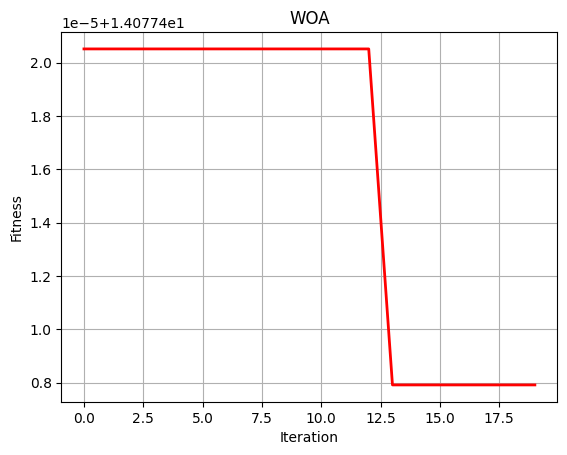

In [29]:
# 设置参数
pop = 5  # 种群数量
MaxIter = 20 # 最大迭代次数
dim = 2  # 维度
lb = [2,100]   # 下边界
ub = [10,3000]   # 上边界
start_time = time.time()  # 记录开始时间
GbestScore, GbestPositon, Curve = WOA(pop, dim, lb, ub, MaxIter, fun)
end_time = time.time()  # 记录结束时间
execution_time = end_time - start_time  # 计算代码执行时间
print("代码执行时间：", execution_time, "秒")
print('最优适应度值：', GbestScore)
print('最优解：', GbestPositon)

# 绘制适应度曲线
plt.figure(1)
plt.plot(Curve, 'r-', linewidth=2)
plt.xlabel('Iteration', fontsize='medium')
plt.ylabel("Fitness", fontsize='medium')
plt.grid()
plt.title('WOA', fontsize='large')

In [ ]:
代码执行时间： 942.1657581329346 秒
代码执行时间：代码执行时间： 817.1307945251465 秒
"""
[[2, 100], [10, 3000]]
[[7.000e+00 1.134e+03]
 [2.000e+00 1.583e+03]
 [2.000e+00 2.948e+03]
 [7.000e+00 2.682e+03]
 [5.000e+00 1.749e+03]
 [9.000e+00 1.491e+03]
 [4.000e+00 1.629e+03]
 [2.000e+00 2.089e+03]
 [3.000e+00 1.954e+03]
 [5.000e+00 3.280e+02]
 [5.000e+00 8.520e+02]
 [6.000e+00 5.160e+02]
 [4.000e+00 8.350e+02]
 [8.000e+00 1.603e+03]
 [6.000e+00 1.210e+03]
 [8.000e+00 2.805e+03]
 [2.000e+00 1.019e+03]
 [6.000e+00 2.205e+03]
 [2.000e+00 9.350e+02]
 [7.000e+00 2.594e+03]]
['迭代次数为0 的迭代结果[9.88159828]']
['迭代次数为0 的最优参数[[  5. 100.]]']
['迭代次数为1 的迭代结果[9.8719624]']
['迭代次数为1 的最优参数[[  5. 121.]]']
['迭代次数为2 的迭代结果[9.8719624]']
['迭代次数为2 的最优参数[[  5. 121.]]']
['迭代次数为3 的迭代结果[9.8719624]']
['迭代次数为3 的最优参数[[  5. 121.]]']
['迭代次数为4 的迭代结果[9.8695062]']
['迭代次数为4 的最优参数[[  5. 127.]]']
['迭代次数为5 的迭代结果[9.8695062]']
['迭代次数为5 的最优参数[[  5. 127.]]']
['迭代次数为6 的迭代结果[9.86302133]']
['迭代次数为6 的最优参数[[  5. 145.]]']
['迭代次数为7 的迭代结果[9.86001569]']
['迭代次数为7 的最优参数[[  5. 156.]]']
['迭代次数为8 的迭代结果[9.85869852]']
['迭代次数为8 的最优参数[[  5. 170.]]']
['迭代次数为9 的迭代结果[9.85869852]']
['迭代次数为9 的最优参数[[  5. 170.]]']
['迭代次数为10 的迭代结果[9.85869852]']
['迭代次数为10 的最优参数[[  5. 170.]]']
['迭代次数为11 的迭代结果[9.85869852]']
['迭代次数为11 的最优参数[[  5. 170.]]']
['迭代次数为12 的迭代结果[9.85869852]']
['迭代次数为12 的最优参数[[  5. 170.]]']
['迭代次数为13 的迭代结果[9.85869852]']
['迭代次数为13 的最优参数[[  5. 170.]]']
['迭代次数为14 的迭代结果[9.85869852]']
['迭代次数为14 的最优参数[[  5. 170.]]']
['迭代次数为15 的迭代结果[9.85869852]']
['迭代次数为15 的最优参数[[  5. 170.]]']
['迭代次数为16 的迭代结果[9.85869852]']
['迭代次数为16 的最优参数[[  5. 170.]]']
['迭代次数为17 的迭代结果[9.85869852]']
['迭代次数为17 的最优参数[[  5. 170.]]']
['迭代次数为18 的迭代结果[9.85869852]']
['迭代次数为18 的最优参数[[  5. 170.]]']
['迭代次数为19 的迭代结果[9.85869852]']
['迭代次数为19 的最优参数[[  5. 170.]]']
['迭代次数为20 的迭代结果[9.85869852]']
['迭代次数为20 的最优参数[[  5. 170.]]']
['迭代次数为21 的迭代结果[9.85869852]']
['迭代次数为21 的最优参数[[  5. 170.]]']
['迭代次数为22 的迭代结果[9.85869852]']
['迭代次数为22 的最优参数[[  5. 170.]]']
['迭代次数为23 的迭代结果[9.85869852]']
['迭代次数为23 的最优参数[[  5. 170.]]']
['迭代次数为24 的迭代结果[9.85861775]']
['迭代次数为24 的最优参数[[  5. 168.]]']
['迭代次数为25 的迭代结果[9.85849931]']
['迭代次数为25 的最优参数[[  5. 166.]]']
['迭代次数为26 的迭代结果[9.85849931]']
['迭代次数为26 的最优参数[[  5. 166.]]']
['迭代次数为27 的迭代结果[9.85849931]']
['迭代次数为27 的最优参数[[  5. 166.]]']
['迭代次数为28 的迭代结果[9.85849931]']
['迭代次数为28 的最优参数[[  5. 166.]]']
['迭代次数为29 的迭代结果[9.85849931]']
['迭代次数为29 的最优参数[[  5. 166.]]']
['迭代次数为30 的迭代结果[9.85849931]']
['迭代次数为30 的最优参数[[  5. 166.]]']
['迭代次数为31 的迭代结果[9.85849931]']
['迭代次数为31 的最优参数[[  5. 166.]]']
['迭代次数为32 的迭代结果[9.85849931]']
['迭代次数为32 的最优参数[[  5. 166.]]']
['迭代次数为33 的迭代结果[9.85849931]']
['迭代次数为33 的最优参数[[  5. 166.]]']
['迭代次数为34 的迭代结果[9.85849931]']
['迭代次数为34 的最优参数[[  5. 166.]]']
['迭代次数为35 的迭代结果[9.85849931]']
['迭代次数为35 的最优参数[[  5. 166.]]']
['迭代次数为36 的迭代结果[9.85849931]']
['迭代次数为36 的最优参数[[  5. 166.]]']
['迭代次数为37 的迭代结果[9.85849931]']
['迭代次数为37 的最优参数[[  5. 166.]]']
['迭代次数为38 的迭代结果[9.85849931]']
['迭代次数为38 的最优参数[[  5. 166.]]']
['迭代次数为39 的迭代结果[9.85849931]']
['迭代次数为39 的最优参数[[  5. 166.]]']
最优适应度值： [9.85849931]
最优解： [[  5. 166.]]


"""




"""
局部样本熵
[[7.000e+00 1.580e+03]
 [3.000e+00 1.238e+03]
 [2.000e+00 1.354e+03]
 [8.000e+00 1.398e+03]
 [7.000e+00 2.064e+03]
 [6.000e+00 1.121e+03]
 [3.000e+00 2.902e+03]
 [8.000e+00 1.791e+03]
 [9.000e+00 2.179e+03]
 [4.000e+00 1.867e+03]
 [2.000e+00 2.092e+03]
 [2.000e+00 2.956e+03]
 [3.000e+00 2.523e+03]
 [3.000e+00 2.493e+03]
 [3.000e+00 7.350e+02]
 [3.000e+00 2.290e+03]
 [8.000e+00 2.118e+03]
 [5.000e+00 2.770e+03]
 [3.000e+00 1.449e+03]
 [4.000e+00 7.190e+02]]
['迭代次数为0 的迭代结果[9.88159828]']
['迭代次数为0 的最优参数[[  5. 100.]]']
['迭代次数为1 的迭代结果[9.88159828]']
['迭代次数为1 的最优参数[[  5. 100.]]']
['迭代次数为2 的迭代结果[9.88159828]']
['迭代次数为2 的最优参数[[  5. 100.]]']
['迭代次数为3 的迭代结果[9.88159828]']
['迭代次数为3 的最优参数[[  5. 100.]]']
['迭代次数为4 的迭代结果[9.88159828]']
['迭代次数为4 的最优参数[[  5. 100.]]']
['迭代次数为5 的迭代结果[9.87598519]']
['迭代次数为5 的最优参数[[  5. 112.]]']
['迭代次数为6 的迭代结果[9.87598519]']
['迭代次数为6 的最优参数[[  5. 112.]]']
['迭代次数为7 的迭代结果[9.87598519]']
['迭代次数为7 的最优参数[[  5. 112.]]']
['迭代次数为8 的迭代结果[9.87598519]']
['迭代次数为8 的最优参数[[  5. 112.]]']
['迭代次数为9 的迭代结果[9.87598519]']
['迭代次数为9 的最优参数[[  5. 112.]]']
['迭代次数为10 的迭代结果[9.87598519]']
['迭代次数为10 的最优参数[[  5. 112.]]']
['迭代次数为11 的迭代结果[9.87279416]']
['迭代次数为11 的最优参数[[  5. 119.]]']
['迭代次数为12 的迭代结果[9.85960598]']
['迭代次数为12 的最优参数[[  5. 158.]]']
['迭代次数为13 的迭代结果[9.85960598]']
['迭代次数为13 的最优参数[[  5. 158.]]']
['迭代次数为14 的迭代结果[9.85960598]']
['迭代次数为14 的最优参数[[  5. 158.]]']
['迭代次数为15 的迭代结果[9.85960598]']
['迭代次数为15 的最优参数[[  5. 158.]]']
['迭代次数为16 的迭代结果[9.85960598]']
['迭代次数为16 的最优参数[[  5. 158.]]']
['迭代次数为17 的迭代结果[9.85960598]']
['迭代次数为17 的最优参数[[  5. 158.]]']
['迭代次数为18 的迭代结果[9.85960598]']
['迭代次数为18 的最优参数[[  5. 158.]]']
['迭代次数为19 的迭代结果[9.85960598]']
['迭代次数为19 的最优参数[[  5. 158.]]']
['迭代次数为20 的迭代结果[9.85960598]']
['迭代次数为20 的最优参数[[  5. 158.]]']
['迭代次数为21 的迭代结果[9.8594586]']
['迭代次数为21 的最优参数[[  5. 177.]]']
['迭代次数为22 的迭代结果[9.85861775]']
['迭代次数为22 的最优参数[[  5. 168.]]']
['迭代次数为23 的迭代结果[9.85849931]']
['迭代次数为23 的最优参数[[  5. 166.]]']
['迭代次数为24 的迭代结果[9.85849931]']
['迭代次数为24 的最优参数[[  5. 166.]]']
['迭代次数为25 的迭代结果[9.85849931]']
['迭代次数为25 的最优参数[[  5. 166.]]']
['迭代次数为26 的迭代结果[9.85849931]']
['迭代次数为26 的最优参数[[  5. 166.]]']
['迭代次数为27 的迭代结果[9.85849931]']
['迭代次数为27 的最优参数[[  5. 166.]]']
['迭代次数为28 的迭代结果[9.85849931]']
['迭代次数为28 的最优参数[[  5. 166.]]']
['迭代次数为29 的迭代结果[9.85849931]']
['迭代次数为29 的最优参数[[  5. 166.]]']
['迭代次数为30 的迭代结果[9.85849931]']
['迭代次数为30 的最优参数[[  5. 166.]]']
['迭代次数为31 的迭代结果[9.85849931]']
['迭代次数为31 的最优参数[[  5. 166.]]']
['迭代次数为32 的迭代结果[9.85849931]']
['迭代次数为32 的最优参数[[  5. 166.]]']
['迭代次数为33 的迭代结果[9.85849931]']
['迭代次数为33 的最优参数[[  5. 166.]]']
['迭代次数为34 的迭代结果[9.85849931]']
['迭代次数为34 的最优参数[[  5. 166.]]']
['迭代次数为35 的迭代结果[9.85849931]']
['迭代次数为35 的最优参数[[  5. 166.]]']
['迭代次数为36 的迭代结果[9.85849931]']
['迭代次数为36 的最优参数[[  5. 166.]]']
['迭代次数为37 的迭代结果[9.85849931]']
['迭代次数为37 的最优参数[[  5. 166.]]']
['迭代次数为38 的迭代结果[9.85849931]']
['迭代次数为38 的最优参数[[  5. 166.]]']
['迭代次数为39 的迭代结果[9.85849931]']
['迭代次数为39 的最优参数[[  5. 166.]]']
最优适应度值： [9.85849931]
最优解： [[  5. 166.]]

"""